 ## Introduction
 ---------------
 This study examines the use of GPT and Azure Cloud to automate the initial stages of scientific research and evaluate the ability of Large Language Models to capture semantic meaning. Scientific literature is analyzed by embedding text into high-dimensional vectors and measuring similarity using cosine similarity, Euclidean distance, and k-means clustering. Experiments were conducted on open-access papers from NASA’s ADS within the sub-domain of colliding galaxies. Cosine similarity grids were created to evaluate comparisons between papers, confirming a strong diagonal correlation when comparing the same papers. The methodology successfully identified similar papers, including those sharing authorship and themes. By addressing context window limitations through chunking, this Retrieval-Augmented Generation (RAG) approach offers a generalizable framework for automated literature review, hypothesis generation, and scientific data organization across various research domains.
 

----------------------
## Table of Contents
--------------------
- [Introduction](#introduction)
- [Importing Libraries](#importing-libraries)
  - [API Key Security](#api-key-security)
- [Data Collection](#data-collection)
  - [HTTP Requests](#http-request-for-initial-data-capture)
- [Data Processing](#data-processing)
  - [Text Normalization](#text-normalization)
  - [Text Summarization](#text-summarization)
  - [Embedding](#embedding)
  - [Context Window](#context-window)
- [Data Storage](#data-storage)
- [Data Query](#data-query)
- [Data Analysis](#data-analysis)
  - [Euclidean Similarity](#1-euclidean-similarity)
  - [Cosine Similarity](#2-cosine-similarity)
  - [K-Clustering](#3-k-clustering)
- [Results](#results)
- [Conclusion](#conclusion)

----------------------
## Importing Libraries
----------------------

In [2]:
import numpy as np
import pandas as pd
import os
import re
import OpenAI
import tiktoken
from typing import Any, Dict, List, Tuple
from transformers import pipeline
import num2words
from PyPDF2 import PdfReader

In this section, we import the necessary Python libraries for various tasks throughout the project:

- **`numpy`**: Supports large, multi-dimensional arrays and matrices, used for numerical computations.
  
- **`pandas`**: Provides data structures like DataFrames, ideal for data manipulation and analysis.

- **`os`**: Interacts with the operating system, useful for file and directory manipulation.

- **`re`**: Handles regular expressions for text parsing and pattern matching.

- **`OpenAI`**: Interfaces with OpenAI's API for tasks like text generation and analysis.

- **`tiktoken`**: Tokenizes text inputs, preparing them for model processing.

- **`typing`**: Provides type hints to improve code clarity and reliability.

- **`transformers`**: Includes pre-trained models for NLP tasks, used via the `pipeline` function.

- **`num2words`**: Converts numbers to words, useful for text formatting.

- **`PyPDF2`**: Extracts text from PDFs, essential for processing academic papers.


## API Key Security

When working with APIs, it's crucial to keep your API keys secure to prevent unauthorized access to your account and data. Storing API keys directly in your code can expose them to potential security risks, such as accidental exposure in version control systems or when sharing code with others. 

### Why Use Environment Variables?

Setting your OpenAI API key as an environment variable is a best practice for securing sensitive information. Environment variables are stored outside your codebase, which means they are not included in your source code files. This approach offers several benefits:

- **Security**: By keeping the API key out of your code, you reduce the risk of accidentally exposing it in public repositories or through code sharing.
- **Flexibility**: Environment variables allow you to easily switch between different API keys or configurations without modifying your code.
- **Portability**: Environment variables can be used across different environments (e.g., local development, staging, production) without hardcoding sensitive information.

### Setting Up Your OpenAI API Key

The following code is an example of setting your OpenAI API key as an environment variable:

In [ ]:
os.environ["OPENAI_API_KEY"] = 'YOUR_API_KEY'

client = OpenAI(
    organization='org-number',
)

------------------
## Data Collection
------------------

### 1. Determine Scope
The first step in data collection is to define the scope of your research. For this project, the goal is to create a database containing approximately 300 to 500 papers focused on the topic of colliding galaxies. By setting a specific range, you ensure that the dataset is manageable while still providing enough data for meaningful analysis.

### 2. Fetch Papers
To gather the necessary papers, you can use a combination of APIs and web scraping techniques:

- **APIs**: Leverage APIs from scientific databases and publishers, such as the NASA Astrophysics Data System (ADS) or other relevant repositories, to programmatically search and retrieve papers.
- **Web Scraping**: For sources that do not provide an API, consider using web scraping tools to extract papers directly from journal websites.

The focus will be on collecting papers from *The Astrophysical Journal*, a leading publication in the field. This ensures that the dataset is composed of high-quality, peer-reviewed articles relevant to your research on colliding galaxies.

### Considerations
- **Data Quality**: Ensure that the papers collected are relevant by filtering out unrelated content. This can be achieved by refining search queries and using keywords specific to colliding galaxies.
- **Metadata Collection**: Alongside the full text, gather important metadata such as the paper’s title, authors, publication date, and DOI. This metadata will be useful for organizing and referencing the papers in the database.
- **Legal Compliance**: Be mindful of copyright laws and access restrictions when collecting papers, especially when using web scraping. Ensure that your methods comply with the terms of use of the sources you are accessing.

By carefully planning and executing the data collection process, you can build a robust database that serves as a strong foundation for your analysis of colliding galaxies.



### HTTP Request for Initial Data Capture

The following screenshot shows the HTTP request used to automate the initial data capture process.


![HTTP Request for initial automated data capture](images/HTTP.png)

### Parsing JSON Response and Creating a DataFrame

The following Python script parses the JSON response from NASA ADS, extracts details for 100 articles on colliding galaxies, and organizes them into a pandas DataFrame with the fields: **bibcode**, **title**, **abstract**, and **PDF link**.


In [ ]:
import json
import pandas as pd
import ast

# Load the JSON data from the file
with open('/Users/ian/output.json', 'r') as f:
    data = json.load(f)

# Extracting relevant information
articles = data['response']['docs']
article_data = []

#print("Number of articles found:", len(articles))

for article in articles:
    title = article['title'][0] if article['title'] else 'No Title'
    abstract = article.get('abstract', 'No abstract available')
    bibcode = article.get('bibcode', 'No Bibcode available')
    
    # Extracting PDF links from links_data
    pdf_url = None
    for link in article['links_data']:
        link_dict = json.loads(link)
        #print("Link data:", link_dict)  # Check the link data
        if link_dict.get('type') in ['pdf', 'preprint']:  # Adjusted check
            pdf_url = link_dict.get('url', 'No URL available')
            break

    # Only add the article if a PDF is available
    if pdf_url:
        article_data.append({
            'Title': title,
            'Abstract': abstract,
            'Bibcode': bibcode,
            'PDF Link': pdf_url
        })

    # Stop if we have 100 articles with PDFs
    if len(article_data) >= 100:
        break

# Create DataFrame
df = pd.DataFrame(article_data)

# Add index column
df.reset_index(drop=False, inplace=True)
df.rename(columns={'index': 'Index'}, inplace=True)

# Save to a CSV file
df.to_csv('/Users/ian/articles.csv', index=False)

print("Data saved to articles.csv")


### Making links from ADS Addresses in JSON response

A python script that updates the link for each article in the dataframe to ensure our program can read each article in full.

In [ ]:
# Load the CSV file
df = pd.read_csv('/Users/ian/articles.csv')

# Replace 'abs' with 'pdf' in the 'PDF Link' column
df['PDF Link'] = df['PDF Link'].str.replace('abs', 'pdf')

# Save the updated DataFrame to a new CSV file
df.to_csv('/Users/ian/updated_articles.csv', index=False)

print("PDF links updated and saved to updated_articles.csv")

### PDF-Reader

This code iterates through the Dataframe and follows the links for each article. It reads each article in full and places it back in the dataframe.

In [ ]:
import pandas as pd
import requests
from PyPDF2 import PdfReader
import io

# Load the updated CSV file
df = pd.read_csv('/Users/ian/updated_articles.csv')

# Step 1: Add a new column 'PDF Content'
df['PDF Content'] = None

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = []
    for page in reader.pages:
        text.append(page.extract_text())
    return '\n'.join(text)  # Join the text of all pages

# Step 2: Download PDFs and extract content
for index, row in df.iterrows():
    pdf_link = row['PDF Link']  # Assuming 'PDF Link' is the correct column name
    try:
        response = requests.get(pdf_link)
        response.raise_for_status()  # Raise an error for bad responses
        
        # Read the PDF from bytes
        pdf_reader = PdfReader(io.BytesIO(response.content))
        text_content = []
        for page in pdf_reader.pages:
            text_content.append(page.extract_text())
        df.at[index, 'PDF Content'] = '\n'.join(text_content)
    
    except Exception as e:
        print(f"Error downloading or reading {pdf_link}: {e}")

# Save the DataFrame with the new column back to CSV
df.to_csv('/Users/ian/updated_articles_with_content.csv', index=False)


------------------
## Data Processing
------------------

In this stage, we process the dataframe as a whole by iterating through each article invidividually.

First we normalized the abstracts and full texts of each article. Text normalization is the process of standardizing text by converting it to lowercase, removing punctuation, and handling special characters to ensure consistency. This step improves the quality of embeddings by reducing redundant variations of words and phrases.

Next we summarized each abstract and paper in the dataframe using GPT 3.5.  Then, each abstact, abstract summary, full article and full article summary was embedded and put back in the dataframe.

- **Full Paper Analysis**: Utilize OpenAI models to thoroughly read and analyze the entire text of each paper. This step helps in extracting critical information and understanding the content at a deeper level.

- **Vector Embedding**: Convert the full text into high-dimensional vectors using embedding techniques. High-dimensional vectors are numerical representations of the text, where each dimension captures a different aspect of the content. These vectors enable complex semantic relationships within the text to be captured, allowing for detailed analysis and comparison between papers. In essence, embedding transforms textual data into a format that models can understand and process, making it easier to analyze similarities, differences, and patterns in large datasets.

- **Generate Abstracts**: Automatically create AI-generated abstracts for each paper, if needed. These summaries provide a quick overview of the content, aiding in the efficient review of large collections of papers.

For a more in-depth discussion on embedding and clustering techniques, [read more on Towards Data Science](https://towardsdatascience.com/introduction-to-embedding-clustering-and-similarity-11dd80b00061).



### Text Normalization

Text normalization is the process of standardizing text by converting it to lowercase, removing punctuation, and handling special characters to ensure consistency. This step improves the quality of embeddings by reducing redundant variations of words and phrases.

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/Users/ian/updated_articles_with_summaries.csv')

# Function to normalize text
def normalize_text(s, sep_token=" \n "):
    s = re.sub(r'\s+', ' ', s).strip()
    s = re.sub(r"\.\s*,", "", s)  # Fix typo here
    s = s.replace("..", ".")
    s = s.replace(". .", ".")
    s = s.replace("\n", "")
    s = s.strip()
    return s

# Normalize the text and replace it in the same column
df['GPT Summary'] = df['GPT Summary'].apply(lambda x: normalize_text(x) if pd.notnull(x) else x)

# Save the DataFrame back to CSV
df.to_csv('/Users/ian/updated_articles_with_normalized_summary.csv', index=False)


### Text Summarization

We used our deployment on Azure of GPT 3.5 to summarize each abstract and article.  In early versions of my Summary scripts I devised an algorithm that was used to adjust the max tokens and temperature of the summaries.  I found that the variance in response I received from this algorithm did not allow for us to accurately analyze the models capabilities in sumarizing and analyzing similarity in our database.  I decided to keep the summary scripts very simple and to set a max token output of 150 tokens.  This was done to ensure the model was summarizing each article under the same parameters.

In [ ]:
import os
import time
import requests
import pandas as pd
import tiktoken

# Load environment variables
GPT35_KEY = os.getenv('GPT35_KEY')
GPT35_ENDPOINT = os.getenv('GPT35_ENDPOINT')

tokenizer = tiktoken.get_encoding("cl100k_base")

# Load the CSV file into a DataFrame
csv_file_path = '/Users/ian/updated_articles_with_content_embeddings.csv'
print(f"Loading CSV file from {csv_file_path}...")
df = pd.read_csv(csv_file_path)
print("CSV file loaded successfully.")

# Add a new column for GPT summaries
df['GPT Summary'] = None

# Function to chunk text
def chunk_text(text, max_tokens):
    tokens = tokenizer.encode(text)
    chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [tokenizer.decode(chunk) for chunk in chunks]

# Function to generate summary for a chunk of text
def generate_summary_for_chunk(chunk):
    headers = {
        "Content-Type": "application/json",
        "api-key": GPT35_KEY,
    }
    data = {
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Summarize the following article:\n\n{chunk}"}
        ],
        "max_tokens": 150,  # Fixed output token length for summaries
        "temperature": 0.7,
    }
    response = requests.post(GPT35_ENDPOINT, headers=headers, json=data)
    response.raise_for_status()
    summary = response.json()["choices"][0]["message"]["content"]
    return summary

# Generate summaries for each row in the DataFrame
for index, row in df.iterrows():
    if pd.notnull(row['PDF Content']):
        chunks = chunk_text(row['PDF Content'], 3900)  # Adjust max_tokens as needed
        total_chunks = len(chunks)
        summaries = []
        for i, chunk in enumerate(chunks):
            print(f"Processing chunk {i + 1} of {total_chunks} for row {index}...")
            summary = generate_summary_for_chunk(chunk)
            summaries.append(summary)
            time.sleep(1)  # Add a delay to avoid hitting rate limits
        df.at[index, 'GPT Summary'] = ' '.join(summaries)
        print(f"Row {index} summarized.")

# Save the updated DataFrame to a new CSV
output_csv_path = '/Users/ian/updated_articles_with_summaries.csv'
df.to_csv(output_csv_path, index=False)
print(f"Updated DataFrame with summaries saved to {output_csv_path}")

### Embedding

An embedding is a numerical representation of text (or other data) in a continuous vector space, where similar items are placed closer together based on their meaning or context. In natural language processing, embeddings transform words, sentences, or documents into dense vectors of fixed dimensions, capturing semantic relationships and patterns in the data. These embeddings enable machines to analyze and compare text efficiently, serving as input for tasks like search, classification, and clustering. Popular embedding models include Word2Vec, GloVe, and transformer-based models like OpenAI's embedding API.

We did all of our embedding with our deployment of Open AI's text-embedding-3-large.  It has 120,000 tokens per minute and a request rate limit of 720 per minute. This model has a context wimdow limitation of 8191 tokens (and the query must be factored into that).  Context window limitations are discussed in detail below.

Below is a python script that was used to embed our dataframe.


In [ ]:
import time
import json
import requests
import pandas as pd
import os
import tiktoken

# Load environment variables
EMBEDDING_ENDPOINT = os.getenv('EMBEDDING_ENDPOINT')
EMBEDDING_KEY = os.getenv('EMBEDDING_KEY')

# Check if environment variables are loaded
if not EMBEDDING_ENDPOINT or not EMBEDDING_KEY:
    raise ValueError("EMBEDDING_ENDPOINT and EMBEDDING_KEY must be set")

# Initialize the tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")

# Function to split text into chunks by tokens
def chunk_text_by_tokens(text, tokenizer, max_tokens_per_chunk=7000):
    token_ids = tokenizer.encode(text)
    chunks = [tokenizer.decode(token_ids[i:i + max_tokens_per_chunk]) for i in range(0, len(token_ids), max_tokens_per_chunk)]
    return chunks

def embed_pdf_contents(df, EMBEDDING_ENDPOINT, EMBEDDING_KEY):
    def get_embedding(text):
        headers = {
            "Content-Type": "application/json",
            "api-key": EMBEDDING_KEY,
        }
        data = json.dumps({
            "input": text
        })
        response = requests.post(EMBEDDING_ENDPOINT, headers=headers, data=data)
        response.raise_for_status()
        return response.json()["data"][0]["embedding"]  # Adjust based on actual response structure

    # Replace PDF content with embeddings
    for index, row in df.iterrows():
        if pd.notnull(row['PDF Content']):
            try:
                chunks = chunk_text_by_tokens(row['PDF Content'], tokenizer)
                embeddings = [get_embedding(chunk) for chunk in chunks]
                df.at[index, 'Embedded Papers'] = embeddings
                print(f"Processed row {index + 1}/{len(df)}")
            except requests.exceptions.HTTPError as e:
                print(f"Error processing row {index + 1}: {e}")
            time.sleep(2)  # Adjust the sleep time based on your rate limits

    # Save the updated DataFrame to a new CSV
    output_csv_path = '/Users/ian/updated_articles_with_embeddings.csv'
    df.to_csv(output_csv_path, index=False)
    print(f"Updated DataFrame saved to {output_csv_path}")

# Load the CSV file into a DataFrame
csv_file_path = '/Users/ian/updated_articles_with_normalized_content.csv'
print(f"Loading CSV file from {csv_file_path}...")
df = pd.read_csv(csv_file_path)
print("CSV file loaded successfully.")

# Call the function to embed PDF contents
print("Starting to embed PDF contents...")
embed_pdf_contents(df, EMBEDDING_ENDPOINT, EMBEDDING_KEY)
print("Embedding process completed.")

## Context Window

The **context window** refers to the maximum amount of text that a language model like GPT can process at one time. This limit is defined in terms of tokens, which are chunks of text (such as words or parts of words). For example, GPT-4 has a context window of 8,000 to 32,000 tokens, depending on the version.

When analyzing scientific articles, some articles might be too long to fit within this context window. This poses a challenge for processing and summarizing large documents because the model cannot handle the entire text in one go. As a result, the `summarize_article()` function, which is designed to generate a summary of an article, may not work effectively for longer documents that exceed the token limit.

### Token Counting and Strategies for Long Articles

To address this issue, we can introduce **token counter functions** that estimate the number of tokens in a given piece of text. These functions help determine whether an article fits within the context window before processing it. If an article is too long, several strategies can be employed:

- **Chunking**: Split the article into smaller, manageable sections that fit within the context window, summarize each chunk, and then combine the summaries.
- **Selective Summarization**: Focus on key sections of the article, such as the abstract, conclusion, or specific chapters, to create a concise summary.
- **Progressive Summarization**: Summarize the document in stages, where each stage focuses on different parts or layers of the text.

By incorporating token counting and these strategies, we can effectively handle large articles and ensure that the `summarize_article()` function is applied efficiently, without exceeding the model's context window.


------------------
### Data Storage
------------------

- **Initialize DataFrame**: Create a Pandas DataFrame to store the information from the .json repsonse.
- **Stored Data on Each Paper**:
  - Index in dataframe
  - Title of paper
  - Abstract
  - Embedded abstract
  - AI-generated abstract summary
  - Embedded AI-generated abstract summary
  - Bibcode
  - PDF link to text
  - PDF content
  - Embedded text
  - AI-generated summary of text
  - Embedded AI summary of text


Below is a representation of our Pandas Datframe layout:

![Example Dataframe](images/Dataframe.png)

## Data Query

Our LLM deployments can now generate a more nuanced response to specific questions on colliding galaxies with our additional database to reference.​

User can ask questions and enter new papers into the database as needed.

Below is an example of a basic query asking our deployment to find any articles in our database about the Milky Way. Aside from the freedom to query on any topic, the user can customize query responses as needed for their project.

In [ ]:
import os
import json
import requests
import pandas as pd
import time

# Load environment variables
QUERY_ENDPOINT = os.getenv('QUERY_ENDPOINT')
QUERY_KEY = os.getenv('QUERY_KEY')

# Check if environment variables are loaded
if not QUERY_ENDPOINT or not QUERY_KEY:
    raise ValueError("QUERY_ENDPOINT and QUERY_KEY must be set")

def query_llm(content, QUERY_ENDPOINT, QUERY_KEY):
    headers = {
        "Content-Type": "application/json",
        "api-key": QUERY_KEY,
    }
    data = json.dumps({
        "prompt": f"Is this article about the Milky Way? {content}",
        "max_tokens": 100  # Adjust based on your needs
    })
    response = requests.post(QUERY_ENDPOINT, headers=headers, data=data)
    response.raise_for_status()
    return response.json()  # Adjust based on actual response structure

def find_articles_about_milky_way(df, QUERY_ENDPOINT, QUERY_KEY):
    results = []
    for index, row in df.iterrows():
        if pd.notnull(row['PDF Content']):
            try:
                response = query_llm(row['PDF Content'], QUERY_ENDPOINT, QUERY_KEY)
                answer = response['choices'][0]['text'].strip()  # Adjust based on actual response structure
                if "yes" in answer.lower():
                    results.append((index, row['Title'], answer))
                print(f"Processed row {index + 1}/{len(df)}")
            except requests.exceptions.HTTPError as e:
                print(f"Error processing row {index + 1}: {e}")
            time.sleep(1)  # Adjust the sleep time based on your rate limits
    return results

# Load the CSV file into a DataFrame
csv_file_path = '/Users/ian/updated_articles_with_normalized_content.csv'
print(f"Loading CSV file from {csv_file_path}...")
df = pd.read_csv(csv_file_path)
print("CSV file loaded successfully.")

# Call the function to find articles about the Milky Way
print("Starting to query articles about the Milky Way...")
results = find_articles_about_milky_way(df, QUERY_ENDPOINT, QUERY_KEY)
print("Query process completed.")

# Display the results
for index, title, answer in results:
    print(f"Article {index} titled '{title}' is about the Milky Way: {answer}")

------------------------
### Data Analysis
------------------------
### 1. Euclidean Similarity
Euclidean similarity is calculated using the distance between two vectors. For embedded documents, Euclidean distance is calculated in a high dimensional vector space. Euclidean similarity can be calculated with:

$$
d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}
$$

Where $ \mathbf{p_{i}} $ and $ \mathbf{q_{i}} $ are components of vectors $ \mathbf{p} $ and $ \mathbf{q}$. A smaller distance indicates greater similarity.

> **Note**: A smaller distance indicates greater similarity.

### 2. Cosine Similarity
Cosine similarity measures the cosine of the angle between two vectors, focusing on their direction rather than magnitude. Cosine similarity can be calculated with:

$$
\text{Cosine Similarity} = 1 -  \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = 1 - \frac{ \sum_{i} \mathbf{A_{i}} \mathbf{B_{i}}}{ \sqrt{ \sum_{i} \mathbf{A_{i}^{2}}} \sqrt{ \sum_{i} \mathbf{B_{i}^{2}}} }
$$

Where $ \mathbf{A} \cdot \mathbf{B} $ represents the dot product of vectors $ \mathbf{A} $ and $ \mathbf{B} $, and $ \|\mathbf{A}\| $ and $ \|\mathbf{B}\| $ denote their magnitudes.

### 3. K-Clustering
K-means clustering organizes papers into \( k \) clusters based on their features. The algorithm works as follows:

1. Randomly initialize \( k \) cluster centroids.
2. Assign each paper to the nearest centroid.
3. Recalculate centroids based on the mean of assigned papers.
4. Iterate until convergence.

This method categorizes similar papers into clusters, aiding in the analysis of new papers.

https://towardsdatascience.com/introduction-to-embedding-clustering-and-similarity-11dd80b00061


## Cosine Similarity

Two cosine similarity grids were created to evaluate how well the LLM captured semantic meaning. In the first, the X-axis of the table is the embedded abstracts of the articles, and the Y-axis of the table is the embedded AI summaries of the full article. In the second, the table's X-axis is the articles' embedded abstracts, and the Y-axis is the embedded AI summaries of those abstracts. Two tables were made to evaluate the LLM because the fact that the abstract is in the full article itself could skew results. This way, the abstract vs abstract grid gives a true comparison of the LLM’s summarization ability. 

The table (or matrix) has N rows and N columns for a sample size of N papers. We populate the matrix with similarity scores between each pair of papers. If the AI summaries are accurate, we expect high similarity along the diagonal (from the top-left to the bottom-right), where the summary of each paper’s abstract closely matches its original. This diagonal pattern indicates a strong correlation between the AI summary and the abstract, reflecting successful summarization. Deviations from this pattern show inconsistency or misrepresentations in the summarizations. Additionally, Euclidean distance and K-means clustering were performed on embedded abstracts and embedded AI summaries of those abstracts.

Below is a python script used to make a Cosine Similarity Grid.

In [ ]:
# Code to make a cosine similarity grid

import pandas as pd
import numpy as np
import ast

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def create_similarity_matrix(df):
    num_papers = len(df)
    similarity_matrix = np.zeros((num_papers, num_papers))

    for i in range(num_papers):
        for j in range(num_papers):
            if pd.notnull(df.at[i, 'Embedded Abstract']) and pd.notnull(df.at[j, 'Embedded Abstract Summary']):
                try:
                    abstract_embedding = ast.literal_eval(df.at[i, 'Embedded Abstract'])
                    summary_embedding = ast.literal_eval(df.at[j, 'Embedded Abstract Summary'])
                    
                    if isinstance(abstract_embedding, list) and isinstance(summary_embedding, list):
                        abstract_embedding = np.array(abstract_embedding, dtype=float)
                        summary_embedding = np.array(summary_embedding, dtype=float)
                        similarity = cosine_similarity(abstract_embedding, summary_embedding)
                        similarity_matrix[i, j] = similarity
                    else:
                        print(f"Non-list embeddings found for rows {i} and {j}")
                except (ValueError, SyntaxError) as e:
                    print(f"Error processing embeddings for rows {i} and {j}: {e}")
            else:
                print(f"Null embeddings found for rows {i} and/or {j}")
        print(f"Completed similarity calculations for row {i + 1}/{num_papers}")

    similarity_df = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)
    return similarity_df

# Load the CSV file into a DataFrame
csv_file_path = '/Users/ian/articles.csv'
print(f"Loading CSV file from {csv_file_path}...")
df = pd.read_csv(csv_file_path)
print("CSV file loaded successfully.")

# Create the similarity matrix
print("Starting to create similarity matrix...")
similarity_df = create_similarity_matrix(df)
print("Similarity matrix creation completed.")

# Save the similarity matrix to a new CSV
output_csv_path = '/Users/ian/cosine_similarity_matrix.csv'
similarity_df.to_csv(output_csv_path, index=True)
print(f"Similarity matrix saved to {output_csv_path}")

### Euclidean Distance

Below is a Python script used to anaylze the Euclidean Distance between each article in the dataframe using the embedded high dimensional vectors.

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

def extract_embedding(embedding_str):
    try:
        embedding_data = ast.literal_eval(embedding_str)
        if isinstance(embedding_data, dict) and 'data' in embedding_data:
            return embedding_data['data'][0]['embedding']
        else:
            return embedding_data  # Assuming it's already a list
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing embedding: {e}")
        return None

def calculate_euclidean_distance(row):
    embedding_abstract = np.array(row['Embedded Abstract'])
    embedding_summary = np.array(row['Embedded Abstract Summary'])
    return np.linalg.norm(embedding_abstract - embedding_summary)

def preprocess_embeddings(df):
    print("Preprocessing embeddings...")
    df['Embedded Abstract'] = df['Embedded Abstract'].apply(
        lambda x: extract_embedding(x) if pd.notnull(x) else x
    )
    df['Embedded Abstract Summary'] = df['Embedded Abstract Summary'].apply(
        lambda x: extract_embedding(x) if pd.notnull(x) else x
    )
    print("Preprocessing completed.")
    return df

def get_top_n_closest_pairs(df, n):
    print(f"Sorting and selecting top {n} closest pairs...")
    sorted_df = df.sort_values(by='distance')
    top_n_df = sorted_df.head(n)
    top_n_df = top_n_df[['Index', 'distance', 'Title', 'Bibcode', 'PDF Link']]
    print(f"Top {n} closest pairs selected.")
    return top_n_df

def plot_euclidean_distances(df, top_closest_pairs):
    print("Plotting Euclidean distances...")
    plt.figure(figsize=(10, 7))
    plt.scatter(df.index, df['distance'], c='blue', label='Articles')
    
    for _, row in top_closest_pairs.iterrows():
        index = row['Index']
        plt.plot(index, df['distance'].iloc[index], 'ro')
    
    plt.title('Euclidean Distance Plot')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.legend()
    plt.show()
    print("Plotting completed.")

# Example usage
if __name__ == "__main__":
    print("Loading embeddings DataFrame...")
    embeddings_csv_path = '/Users/ian/articles.csv'
    embeddings_df = pd.read_csv(embeddings_csv_path)
    print("Embeddings DataFrame loaded.")
    
    embeddings_df = preprocess_embeddings(embeddings_df)
    
    print("Calculating Euclidean distances...")
    embeddings_df['distance'] = embeddings_df.apply(calculate_euclidean_distance, axis=1)
    print("Euclidean distances calculated.")
    
    print("Loading articles DataFrame...")
    articles_csv_path = '/path/to/articles.csv'
    articles_df = pd.read_csv(articles_csv_path)
    print("Articles DataFrame loaded.")
    
    top_n = 20
    top_n_df = get_top_n_closest_pairs(embeddings_df, top_n)
    
    top_n_csv_path = '/Users/ian/Euclidean_top_n_closest_pairs.csv'
    top_n_df.to_csv(top_n_csv_path, index=False)
    print(f"Top {top_n} closest pairs saved to {top_n_csv_path}")
    
    plot_euclidean_distances(embeddings_df, top_n_df)

### K-means Clustering

Below is a Python script used to Cluster papers together based on similarity.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import ast

def extract_embedding(embedding_str):
    try:
        embedding_data = ast.literal_eval(embedding_str)
        if isinstance(embedding_data, dict) and 'data' in embedding_data:
            return embedding_data['data'][0]['embedding']
        else:
            return embedding_data  # Assuming it's already a list
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing embedding: {e}")
        return None

# Load the articles data
print("Loading articles data from /Users/ian/articles.csv...")
articles_df = pd.read_csv('/Users/ian/articles.csv')
print("Articles data loaded successfully.")

# Extract embedded abstracts and summaries
print("Extracting embedded abstracts and summaries...")
embedded_abstracts = articles_df['Embedded Abstract'].apply(lambda x: extract_embedding(x) if pd.notnull(x) else [])
embedded_summaries = articles_df['Embedded Abstract Summary'].apply(lambda x: extract_embedding(x) if pd.notnull(x) else [])
print(f"Extracted {len(embedded_abstracts)} embedded abstracts and {len(embedded_summaries)} embedded summaries.")

# Combine embeddings
print("Combining embeddings...")
combined_embeddings = [abstract + summary for abstract, summary in zip(embedded_abstracts, embedded_summaries)]
print("Embeddings combined.")

# Standardize the embeddings
scaler = StandardScaler()
combined_embeddings = scaler.fit_transform(combined_embeddings)
print("Embeddings standardized.")

# Perform KMeans clustering
print("Performing KMeans clustering...")
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters (n_clusters) as needed
articles_df['Cluster'] = kmeans.fit_predict(combined_embeddings)
print("KMeans clustering completed.")

# Reduce the dimensionality of the data to 2D using PCA
print("Reducing dimensionality using PCA...")
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combined_embeddings)
print("Dimensionality reduced.")

# Create a scatter plot with different markers for each cluster
print("Creating scatter plot...")
plt.figure(figsize=(10, 7))
markers = ['o', 's', 'D', '^', 'v']  # Different markers for each cluster
for i in range(5):  # Assuming 5 clusters
    cluster_points = reduced_embeddings[articles_df['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], marker=markers[i], label=f'Cluster {i}')

# Add a legend
plt.legend(title="Clusters")
plt.title("KMeans Clustering Results (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
print("Scatter plot displayed.")

------------------------
### Results
------------------------

## Experiment 1
# Abstract vs PDF



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

<Axes: >

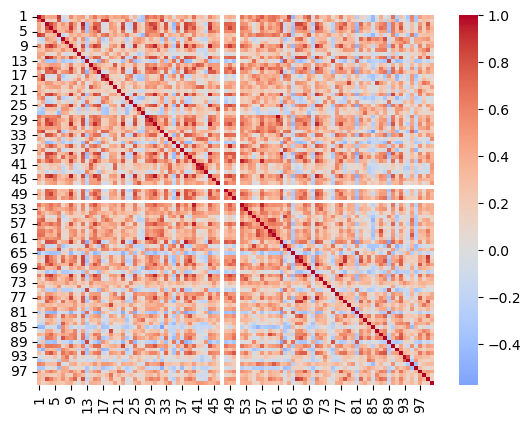

In [8]:
fn = "/Users/ian/THESIS-AB-PDF/cos_sim_AB-PDF.csv"

df = pd.read_csv(fn, header=None)

# Exclude the first column and row
df = df.iloc[1:, 1:]

# Make a correlation plot of the data without annotations
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', center=0)

In [9]:
# create a cell that calculates the average and std of the diagonal and off-diagonal elements of the matrix elements
# fill NaN values with 0
df_filled = df.fillna(0)

# diagonal
diag = np.diag(df_filled)
diag_avg = np.mean(diag)
diag_std = np.std(diag)

# off-diagonal
off_diag = df_filled.values[np.triu_indices(df_filled.shape[0], k=1)]
off_diag_avg = np.mean(off_diag)
off_diag_std = np.std(off_diag)

# print the results
print("Average of diagonal elements: ", diag_avg)
print("Standard deviation of diagonal elements: ", diag_std)
print("Average of off-diagonal elements: ", off_diag_avg)
print("Standard deviation of off-diagonal elements: ", off_diag_std)

Average of diagonal elements:  0.8178291323420618
Standard deviation of diagonal elements:  0.1317291142411361
Average of off-diagonal elements:  0.42907502369471967
Standard deviation of off-diagonal elements:  0.10504423032010693


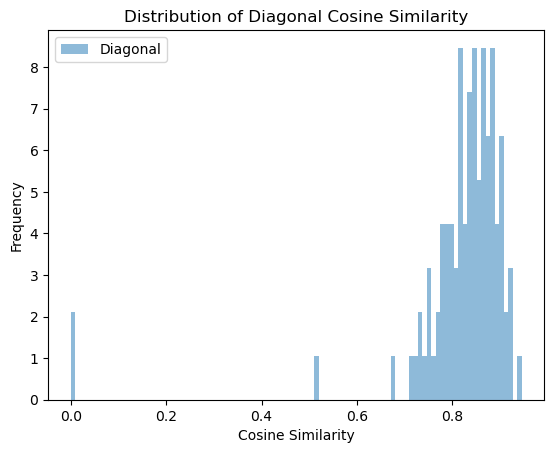

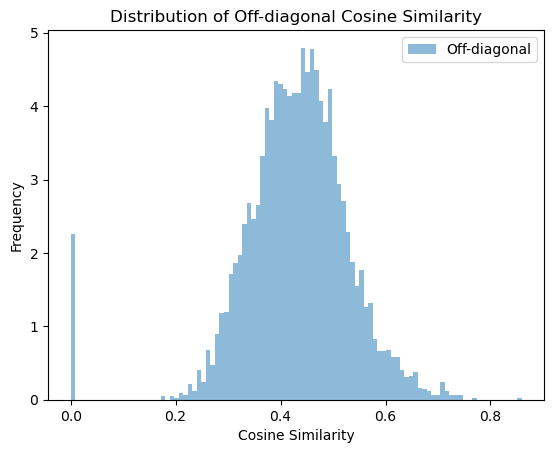

In [10]:
# plot the distribution of the diagonal elements
plt.figure()
nbins = 100
plt.hist(diag, bins=nbins, alpha=0.5, label='Diagonal', density=True)
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Diagonal Cosine Similarity")
plt.show()

# plot the distribution of the off-diagonal elements
plt.figure()
plt.hist(off_diag, bins=nbins, alpha=0.5, label='Off-diagonal', density=True)
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Off-diagonal Cosine Similarity")
plt.show()

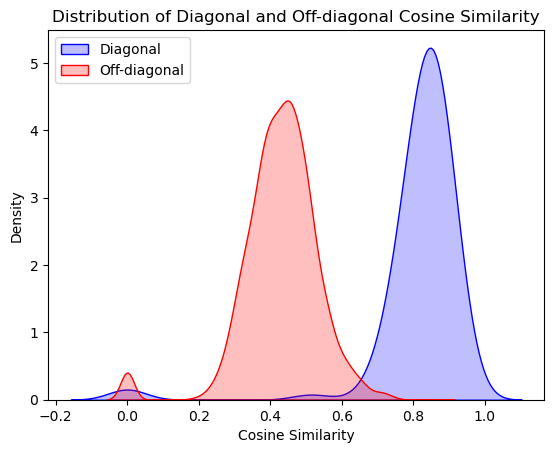

In [11]:
# plot the outline of the two distributions on the same graph - normalize the two scales
plt.figure()
sns.kdeplot(diag, label='Diagonal', color='blue', fill=True)
sns.kdeplot(off_diag, label='Off-diagonal', color='red', fill=True)
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Distribution of Diagonal and Off-diagonal Cosine Similarity")
plt.show()

## Python scripts to anaylyze similarity

In [ ]:
import pandas as pd

n = 10

# Load the similarity matrix CSV file into a DataFrame
similarity_csv_path = '/Users/ian/ABvsAB_cosine_similarity_matrix.csv'
print(f"Loading similarity matrix from {similarity_csv_path}...")
similarity_df = pd.read_csv(similarity_csv_path, index_col=0)
print("Similarity matrix loaded successfully.")

# Load the articles CSV file into a DataFrame
articles_csv_path = '/Users/ian/articles.csv'
print(f"Loading articles data from {articles_csv_path}...")
articles_df = pd.read_csv(articles_csv_path)
print("Articles data loaded successfully.")

# Debug print to check columns of articles_df
print("Columns in articles_df:", articles_df.columns)

# Function to get top N highest similarity scores
def get_top_n_similarities(similarity_df, articles_df, n):
    # Melt the DataFrame to long format
    melted_df = similarity_df.reset_index().melt(id_vars='index')
    melted_df.columns = ['article1', 'article2', 'similarity']
    
    # Convert article1 and article2 to integers
    melted_df['article1'] = melted_df['article1'].astype(int)
    melted_df['article2'] = melted_df['article2'].astype(int)
    
    # Remove self-similarities and duplicate pairs
    melted_df = melted_df[melted_df['article1'] != melted_df['article2']]
    #melted_df = melted_df[melted_df['article1'] < melted_df['article2']]
    
    # Sort by similarity score in descending order
    top_similarities = melted_df.sort_values(by='similarity', ascending=False).head(n)
    
    # Debug print to check the top similarities before merging
    print("Top similarities before merging:")
    print(top_similarities)
    
    # Merge with articles_df to get titles, bibcodes, and PDF links
    top_similarities = top_similarities.merge(articles_df, left_on='article1', right_on='Index')
    top_similarities = top_similarities.merge(articles_df, left_on='article2', right_on='Index', suffixes=('_1', '_2'))
    
    # Select relevant columns
    top_similarities = top_similarities[['article1', 'article2', 'similarity', 'Title_1', 'Bibcode_1', 'PDF Link_1', 'Title_2', 'Bibcode_2', 'PDF Link_2']]
    
    return top_similarities

# Get the top N highest similarity scores
top_similarities = get_top_n_similarities(similarity_df, articles_df, n)

# Print the top similarities
print(f"Top {n} highest similarity scores:")
print(top_similarities)

# Save the top similarities to a new CSV file
output_csv_path = f'/Users/ian/top_{n}_similarities_ABvsAB.csv'
top_similarities.to_csv(output_csv_path, index=False)
print(f"Top similarities saved to {output_csv_path}")

![Highest Cosine Scores](images/Cos1.png)
![Highest Euclidean Scores](images/Euc1.png)

### Euclidean and Kmeans Plots for Experiment 1
![Euclidean plot for Experiment1](images/Eplot1.png)
![Kmeans plot for Experiment1](images/Kplot1.png)

------------------------
### Experiment 2

# Abstract vs Abstract

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

<Axes: >

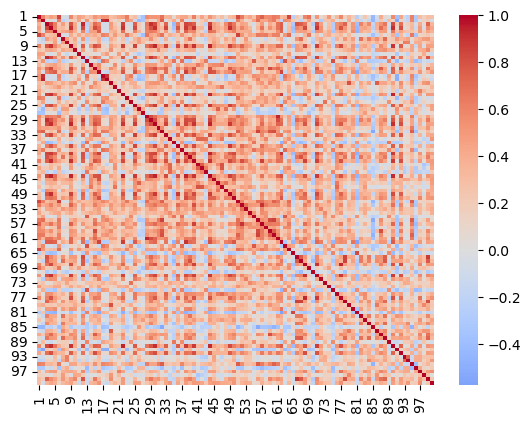

In [3]:
fn = "/Users/ian/Rounded-AB-AB-cos-grid.csv"

df = pd.read_csv(fn, header=None)

# Exclude the first column and row
df = df.iloc[1:, 1:]

# Make a correlation plot of the data without annotations
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', center=0)

In [4]:
# create a cell that calculates the average and std of the diagonal and off-diagonal elements of the matrix elements
# fill NaN values with 0
df_filled = df.fillna(0)

# diagonal
diag = np.diag(df_filled)
diag_avg = np.mean(diag)
diag_std = np.std(diag)

# off-diagonal
off_diag = df_filled.values[np.triu_indices(df_filled.shape[0], k=1)]
off_diag_avg = np.mean(off_diag)
off_diag_std = np.std(off_diag)

# print the results
print("Average of diagonal elements: ", diag_avg)
print("Standard deviation of diagonal elements: ", diag_std)
print("Average of off-diagonal elements: ", off_diag_avg)
print("Standard deviation of off-diagonal elements: ", off_diag_std)

Average of diagonal elements:  0.8917700000000002
Standard deviation of diagonal elements:  0.03734858899610533
Average of off-diagonal elements:  0.43982181818181826
Standard deviation of off-diagonal elements:  0.08815912248600422


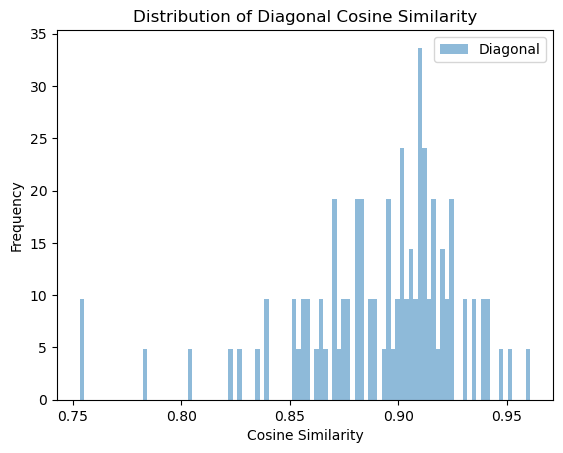

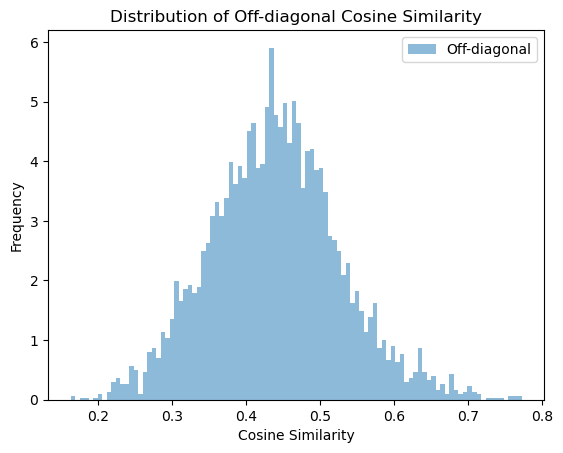

In [5]:
# plot the distribution of the diagonal elements
plt.figure()
nbins = 100
plt.hist(diag, bins=nbins, alpha=0.5, label='Diagonal', density=True)
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Diagonal Cosine Similarity")
plt.show()

# plot the distribution of the off-diagonal elements
plt.figure()
plt.hist(off_diag, bins=nbins, alpha=0.5, label='Off-diagonal', density=True)
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Off-diagonal Cosine Similarity")
plt.show()


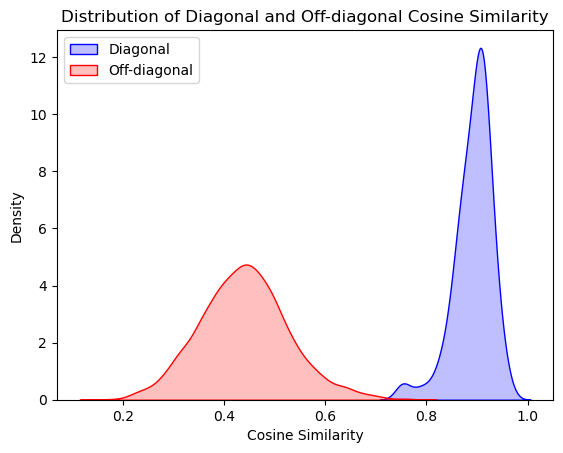

In [6]:
# plot the outline of the two distributions on the same graph - normalize the two scales
plt.figure()
sns.kdeplot(diag, label='Diagonal', color='blue', fill=True)
sns.kdeplot(off_diag, label='Off-diagonal', color='red', fill=True)
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Distribution of Diagonal and Off-diagonal Cosine Similarity")
plt.show()


In [ ]:
# the cumlative distirbvution fuction of the diagonal and off-diagonal elements
plt.figure()
sns.kdeplot(diag, label='Diagonal', color='blue', cumulative=True)
sns.kdeplot(off_diag, label='Off-diagonal', color='red', cumulative=True)
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Cumulative Distribution of Diagonal and Off-diagonal Cosine Similarity")
plt.show()

![](output.png)

## Highest Cosine and Euclidean Scores for Experiment 2
![Highest Cosine scores](images/Cos2.png)
![Highest Euc scores](images/Euc2.png)

### Euclidean and K means plots for Experiment 2
![Euclidean Plot 2](images/Eplot2.png)
![K means Plot 2](images/Kplot2.png)

----------------------
### Conclusions
----------------------

As expected, a strong correlation in the diagonal direction in each cosine similarity grid was found. This indicates that our deployed models correctly ranked the same papers as more similar than when compared to different papers. Additionally, the models (our deployed embedding and GPT models) performed better than expected in similarity evaluations. The models could pick out two papers written on the same topic by the same author as the most similar in the database. Since our data capture was automated, including two papers by the same author on the same subject was unintentional. Still, the results were exciting because this means our models could correctly identify the two most textually and semantically similar papers. Due to the models performing well, we plan to re-run the experiment with a larger dataset, and to create more stringent evaluation methods. One key thing we plan to change in the experiment is to parse the full paper and remove the abstract before embedding the document. This way, when comparing the abstract to the document, the abstract itself will not be present in the document to skew similarity results.